## Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import os
import json
import glob


import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
import torch 
import torchvision
import rasterio as rio
import matplotlib.pyplot as plt
import torchinfo
from torch.utils.tensorboard import SummaryWriter

from models.from_config import build_from_config
from data_handlers.datasets.csv_dataset import CustomDatasetFromDataFrame
from utils import utils, transfer_learning as tl
from train_transfer import train

In [32]:
CSV_PATH=os.path.join('data','geometry_less_dataset.csv')
DATA_DIR=os.path.join('data','landsat_tif','')

In [33]:
# Add filenames:
csv = pd.read_csv(CSV_PATH)
csv['filename']=csv.apply(
    lambda row:  str(row['lat'])[:5].replace('.','_')+"_"+str(row.lon)[:5].replace('.','_')+'.tif', axis=1
)
csv = csv.loc[:, ~csv.columns.str.contains('^Unnamed')]
csv.head()

,country,year,cluster,lat,lon,households,wealthpooled,filename
0,angola,2011,1,-12.350257,13.534922,36,2.312757,-12_3_13_53.tif
1,angola,2011,2,-12.360865,13.551494,32,2.010293,-12_3_13_55.tif
2,angola,2011,3,-12.613421,13.413085,36,0.877744,-12_6_13_41.tif
3,angola,2011,4,-12.581454,13.397711,35,1.066994,-12_5_13_39.tif
4,angola,2011,5,-12.578135,13.418748,37,1.750153,-12_5_13_41.tif


In [34]:
# AND SAVE UPDATED CSV
csv.to_csv(CSV_PATH, index=False)

In [35]:
def show_sample(tile, label, swap_br=True):
    tile_rgb = tile[:3,:,:].numpy()
    tile_rgb = tile_rgb.transpose((1,2,0))
    tile_rgb = (tile_rgb-tile_rgb.min() )/ (tile_rgb.max()-tile_rgb.min())
    print(tile_rgb.min(), " __ ", tile_rgb.max())
    if swap_br:
        tile_rgb=tile_rgb[:,:,::-1]
    plt.figure()
    plt.imshow((tile_rgb*255).astype(int))
    plt.title('wealth index: '+str(label))
    plt.show()
    return

In [35]:
# COMPUTE MEAN AND STD OF THE WHOLE DATASET
# (DO IT ONCE)
tile_names=glob.glob(os.path.join(DATA_DIR)+'*.tif')
tiles=torch.stack([torch.from_numpy(np.nan_to_num(np.array(rio.open(tile).read())[:,:186,:186])) for tile in tile_names])
means = tiles.view(7, -1).mean(dim=1)
stds = tiles.view(7, -1).std(dim=1)
print(means, stds)
# last output:
# tensor([42.7178, 42.9092, 43.2119, 42.8700, 42.7862, 42.7192, 42.8525]) 
# tensor([104.3150, 104.7388, 105.4271, 104.6307, 104.5374, 104.3182, 104.5891])

tensor([42.7178, 42.9092, 43.2119, 42.8700, 42.7862, 42.7192, 42.8525]) tensor([104.3150, 104.7388, 105.4271, 104.6307, 104.5374, 104.3182, 104.5891])


In [50]:
train_transform = torch.nn.Sequential(
    torchvision.transforms.Resize(size=224),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.Normalize(
        mean=[42.7178, 42.9092, 43.2119, 42.8700, 42.7862, 42.7192, 42.8525],
        std =[104.3150, 104.7388, 105.4271, 104.6307, 104.5374, 104.3182, 104.5891]
        )
)
test_transform  = torch.nn.Sequential(
    torchvision.transforms.Resize(size=224),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.Normalize(
        mean=[42.7178, 42.9092, 43.2119, 42.8700, 42.7862, 42.7192, 42.8525],
        std =[104.3150, 104.7388, 105.4271, 104.6307, 104.5374, 104.3182, 104.5891]
        )
)

In [51]:
cluster_splits = sklearn.model_selection.train_test_split(np.arange(len(csv.cluster.unique())))
# train test split
train_split = np.array([idx for i in cluster_splits[0] for idx,_ in csv[csv.cluster==i].iterrows()])
test_split  = np.array([idx for i in cluster_splits[1] for idx,_ in csv[csv.cluster==i].iterrows()])
# train val split
np.random.shuffle(train_split)
train_split, val_split = train_split[:int(0.9*len(train_split))], train_split[int(0.9*len(train_split)):]

In [52]:
CONFIG_FILE = 'configs/resnet18_ms.json'
with open( CONFIG_FILE ) as f:
    config = json.load(f)

In [53]:
train_df = csv.iloc[train_split]
val_df = csv.iloc[val_split]
test_df = csv.iloc[test_split]

train_dataset = CustomDatasetFromDataFrame(train_df, DATA_DIR, transform=train_transform)
val_dataset = CustomDatasetFromDataFrame(val_df, DATA_DIR, transform=train_transform)
test_dataset  = CustomDatasetFromDataFrame(test_df, DATA_DIR, transform=test_transform)

train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


2. Model Training Phase

In [48]:
import torchgeo.models
writer = SummaryWriter()

In [54]:
# TRANSFER LEARNING SCENARIO
base_model = torchgeo.models.resnet18(weights=torchgeo.models.ResNet18_Weights.SENTINEL2_ALL_MOCO)
model = build_from_config( base_model=base_model, config_file=CONFIG_FILE )
torchinfo.summary(
    model, 
    input_size=(int(config['batch_size']), 7, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 7, 224, 224]    [64, 1]              --                   Partial
├─Conv2d (conv1)                         [64, 7, 224, 224]    [64, 64, 112, 112]   (21,952)             False
├─BatchNorm2d (bn1)                      [64, 64, 112, 112]   [64, 64, 112, 112]   (128)                False
├─ReLU (act1)                            [64, 64, 112, 112]   [64, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [64, 64, 112, 112]   [64, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [64, 64, 56, 56]     [64, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [64, 64, 56, 56]     [64, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [64, 64, 56, 56]     [64, 64, 56, 56]     (36,864)             False
│    │    

In [67]:
# CONFIGURE LOSS, OPTIM
loss_fn = utils.configure_loss( config )
optimizer = utils.configure_optimizer( config, model )
device = "cuda" if torch.cuda.is_available() else "cpu"

In [71]:
results = train(
    model=model,
    train_dataloader=test_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    batch_size=config['batch_size'],
    in_channels=config['in_channels'],
    writer=writer,
    device=device
) 

  0%|          | 0/5 [00:00<?, ?it/s]

3. Test Results

In [76]:
# Get R2 Score
inputs, outputs = model.eval()

914 tensor([-0.5580,  0.8221,  0.9242, -0.1697, -0.6473,  0.2837, -0.7529,  1.7704]) 914 [0.08602249]


In [81]:
inputs = np.array([i.mean() for i in inputs])
outputs = np.array(outputs)
r2 = sklearn.metrics.r2_score(inputs,outputs)
r2

-0.021535949470567806

In [84]:
print(outputs[3])

[0.08602249]


<Axes: >

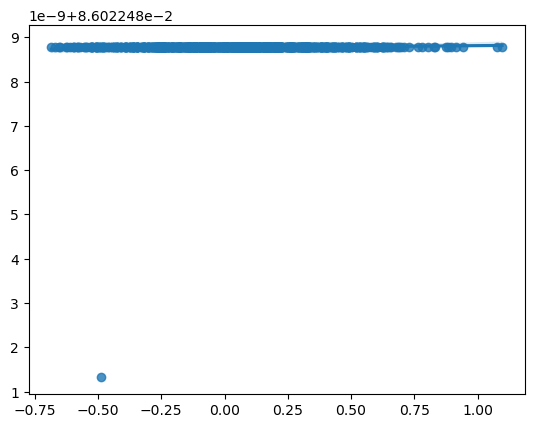

In [78]:
import seaborn as sns
sns.regplot(x=inputs, y=outputs)